In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',cmap='Blues',title='Accumulated Rainfall',levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<10,np.nan,data)
        lat2d,lon2d = np.meshgrid(lats,lons)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)

                # ax.plot(centre_lons,centre_lats,color='black')
                # ax.plot(centre_lons[intensity==1.],centre_lats[intensity==1.],color='white')
        # ax.add_feature(cfeature.LAND) # TODO: fix this as it doesn't work
        ax.outline_patch.set_linewidth(0.5)
        cbar = plt.colorbar(c, shrink=0.68)
        # cbar.outline.set_linewidth(0.5)
        cbar.ax.tick_params(labelsize=6,width=0.5)
        # plt.title(title)

        if plot=='show':
                plt.show()
        else:
                plt.savefig('figs/accumulated_rainfall.png',bbox_inches='tight',dpi=300)

In [3]:
mode = 'validation'
# mode = 'extreme_valid'
# mode = 'cmip'
real = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]
meta = pd.read_csv('/user/work/al18709/tc_data_mswep/valid_meta.csv')
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [4]:
print(real.shape)
print(pred.shape)
print(meta.shape)

(16253, 100, 100)
(16253, 100, 100)
(16253, 5)


In [5]:
# get list of landfalling tcs
landfall_sids = find_landfalling_tcs(meta)
print(landfall_sids)
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in landfall_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

all_sids = list(dict.fromkeys(meta['sid']))
# print(all_sids)
# print(meta)
# print(len(all_sids)) # not sure all sids are being found in the metadata?

['1989142N11114', '2017122S13170', '2013046S20042', '1981307N17279', '2007240N17153', '2014279N11096', '2015273N12130', '2009254N14130', '2000333S11140', '1985199N08143', '1982227N09140', '1999208N06139', '1995206N15133', '2013019S12174', '1993164N04160', '1989153N04144', '1996274N13261', '2006237N13298', '2000273N16277', '1992212N05154', '2005186N12299', '1999236N22292', '2013257N15259', '2008033S11083', '2008262N16142', '2008015S16162', '2007043S11071', '2006180N06140', '2001248N23125', '2001180N15118', '1984207N29135', '1989286N19268', '1991289N06156', '2002297N09206', '1989254N13340', '2007085S11085', '1997196N08142', '1989238N22253', '2006257N16259', '1986169N07152', '2018280N18273', '2013178N09133', '1989271N12142', '2000185N15117', '1985268N16126', '2003247N10153', '2015344N07145', '1985168N05156', '1985240N20286', '1980069S12161', '1989190N20160', '1988242N12215', '2001255N26276', '2015183N13130', '1989006S15044', '1983141N07269', '1985240N08148', '1993229N10159', '2017260N1231

In [6]:
# grab mswep coordinate variables
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon

In [7]:
# clip to entire TC region
# lats,lons = tc_region(meta,sid_2008169N08135,lat,lon) 
# dennis = 2005186N12299
lats,lons = tc_region(meta,sid_2015344N07145,lat,lon)

In [8]:

# initialise accumulated xarray
grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
accumulated_ds = create_xarray(lats,lons,a)
accumulated_ds_pred = create_xarray(lats,lons,a)
accumulated_ds_input = create_xarray(lats,lons,a)


# accumulated = np.zeros(grid_x.shape)
for i in sid_2015344N07145:
	storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
	ds = create_xarray(storm_lats,storm_lons,real[i])
	ds_pred = create_xarray(storm_lats,storm_lons,pred[i])
	input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
	ds_input = create_xarray(input_lats,input_lons,inputs[i])

	# regrid so grids match
	regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
	ds_out = regridder(ds)
	ds_pred_out = regridder(ds_pred)

	# regird the inputs
	regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
	# regridder = xe.Regridder(ds_input, accumulated_ds, "nearest_s2d")
	ds_input_out = regridder(ds_input)

	# add up rainfall
	accumulated_ds = accumulated_ds + ds_out
	accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
	accumulated_ds_input = accumulated_ds_input + ds_input_out


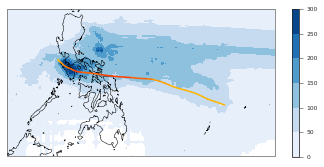

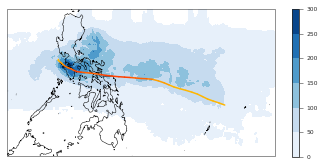

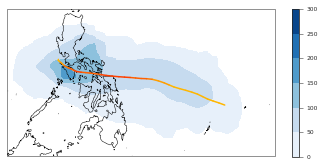

In [9]:
levels = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700]
levels = [0,50,100,150,200,250,300]

storm = '2015344N07145'
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

centre_lats = tracks['lat'].loc[tracks['sid']==storm].reset_index(drop=True)
centre_lons = tracks['lon'].loc[tracks['sid']==storm].reset_index(drop=True)
intensity = tracks['sshs'].loc[tracks['sid']==storm].reset_index(drop=True)
# ibtracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
# 						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
# 						parse_dates = ['ISO_TIME'],keep_default_na=False)
# print(ibtracks)
# centre_lats = ibtracks['LAT'].loc[ibtracks['SID']==storm]
# centre_lons = ibtracks['LON'].loc[ibtracks['SID']==storm]

plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_input['precipitation'],accumulated_ds_input['lat'].values,accumulated_ds_input['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)

# real_accumulated = accumulated_ds
# sns.jointplot(
#     x=accumulated_ds.lon,
#     y=accumulated_ds.lat,
#     data=accumulated_ds.precipitation,
#     kind='kde' # or 'kde' or 'hex'
# )



(37728,)
(37728,)
(37728,)
       Observations  Predicted  Low resolution
0           15.6875   2.450567             0.0
1           15.8125   2.450236             0.0
2           15.8125   2.450561             0.0
3           15.8125   2.445560             0.0
4           15.8125   2.443522             0.0
...             ...        ...             ...
37723       17.5625   6.605333             0.0
37724       17.5625   6.605333             0.0
37725       17.5625   6.605333             0.0
37726       17.5625   6.605333             0.0
37727       17.5625   6.605333             0.0

[37728 rows x 3 columns]


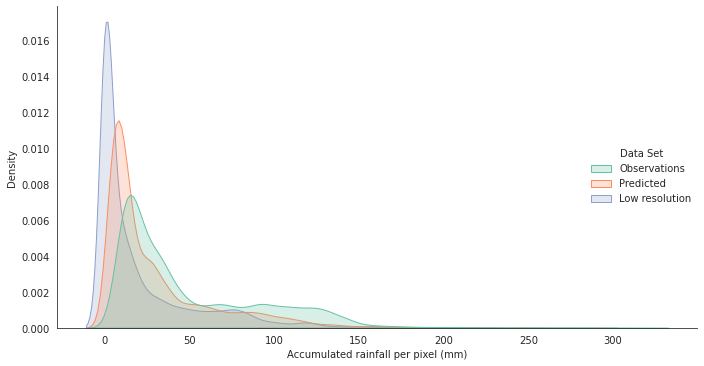

In [10]:
print(accumulated_ds.precipitation.values.flatten().shape)
print(accumulated_ds_pred.precipitation.values.flatten().shape)
print(accumulated_ds_input.precipitation.values.flatten().shape)

rain = pd.DataFrame({
	'Observations':accumulated_ds.precipitation.values.flatten(),
	'Predicted':accumulated_ds_pred.precipitation.values.flatten(),
	'Low resolution':accumulated_ds_input.precipitation.values.flatten(),

})
# sns.displot(accumulated_ds.precipitation.values.flatten(), kind="kde",hue='model',fill='true')
# sns.displot(accumulated_ds_pred.precipitation.values.flatten(), kind="kde",multiple="stack")
# sns.displot(accumulated_ds_input.precipitation.values.flatten(), kind="kde",multiple="stack")
print(rain)
# sns.set(rc={'figure.figsize':(10,5)})
p = sns.displot(rain,kind="kde",fill='true',height=5, aspect=10/5)
p.set(xlabel='Accumulated rainfall per pixel (mm)')
sns.move_legend(p, "upper right", bbox_to_anchor=(.85, .6), title='Data Set')
plt.savefig('figs/accumulated_hist.png',bbox_inches='tight')
point_lat,point_lon = -82.3666, 23.1136


In [29]:
grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
print(a.shape)
n_steps = len(sid_2015344N07145)
time = range(n_steps)
accumulated_ds = create_xarray(lats,lons,a).expand_dims(time=time)
accumulated_ds_pred = create_xarray(lats,lons,a).expand_dims(time=time)
accumulated_ds_input = create_xarray(lats,lons,a).expand_dims(time=time)

print(accumulated_ds.precipitation.shape)

# accumulated = np.zeros(grid_x.shape)
for j,i in enumerate(sid_2015344N07145):
	storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
	ds = create_xarray(storm_lats,storm_lons,real[i])
	ds_pred = create_xarray(storm_lats,storm_lons,pred[i])
	input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
	ds_input = create_xarray(input_lats,input_lons,inputs[i])

	# regrid so grids match
	regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
	ds_out = regridder(ds)
	ds_pred_out = regridder(ds_pred)

	# regird the inputs
	# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
	regridder = xe.Regridder(ds_input, accumulated_ds, "nearest_s2d")
	ds_input_out = regridder(ds_input)

	# add up rainfall
	accumulated_ds = xr.where(accumulated_ds.time == j, ds_out,accumulated_ds)
	accumulated_ds_pred = xr.where(accumulated_ds_pred.time == j, ds_pred_out,accumulated_ds_pred)
	accumulated_ds_input = xr.where(accumulated_ds_input.time == j, ds_input_out,accumulated_ds_input)
	# accumulated_ds.precipitation[j] = ds_out
	# accumulated_ds_pred.precipitation[j] = ds_pred_out
	# accumulated_ds_input.precipitation[j] = ds_input_out

print(accumulated_ds.precipitation)


(262, 144)
(33, 262, 144)
<xarray.DataArray 'precipitation' (time: 33, y: 144, x: 262)>
array([[[0.125 , 0.125 , 0.125 , ..., 0.5   , 0.5   , 0.5   ],
        [0.125 , 0.125 , 0.125 , ..., 0.5   , 0.5   , 0.5   ],
        [0.125 , 0.125 , 0.125 , ..., 0.5   , 0.5   , 0.5   ],
        ...,
        [1.3125, 1.3125, 1.3125, ..., 1.875 , 1.875 , 1.875 ],
        [1.3125, 1.3125, 1.3125, ..., 1.875 , 1.875 , 1.875 ],
        [1.3125, 1.3125, 1.3125, ..., 1.875 , 1.875 , 1.875 ]],

       [[0.3125, 0.3125, 0.3125, ..., 0.4375, 0.4375, 0.4375],
        [0.3125, 0.3125, 0.3125, ..., 0.4375, 0.4375, 0.4375],
        [0.3125, 0.3125, 0.3125, ..., 0.4375, 0.4375, 0.4375],
        ...,
        [0.8125, 0.8125, 0.8125, ..., 0.0625, 0.0625, 0.0625],
        [0.8125, 0.8125, 0.8125, ..., 0.0625, 0.0625, 0.0625],
        [0.8125, 0.8125, 0.8125, ..., 0.0625, 0.0625, 0.0625]],

       [[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],


<xarray.Dataset>
Dimensions:        (time: 33, y: 144, x: 262)
Coordinates:
  * time           (time) int64 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31 32
    lon            (x) float32 114.9 115.1 115.2 115.3 ... 140.9 140.9 141.1
    lat            (y) float32 4.75 4.85 4.95 5.05 ... 18.75 18.85 18.95 19.05
Dimensions without coordinates: y, x
Data variables:
    precipitation  (time, y, x) float64 0.125 0.125 0.125 0.125 ... 0.0 0.0 0.0
(262,)
98
60
[94, 103]
[56, 65]
[14.149997 14.249995 14.350001 14.45     14.549998 14.649997 14.749995
 14.850001 14.95    ]
[120.55     120.65001  120.750015 120.85002  120.95     121.05
 121.15001  121.250015 121.35002 ]
(33, 144, 262)
(33,)


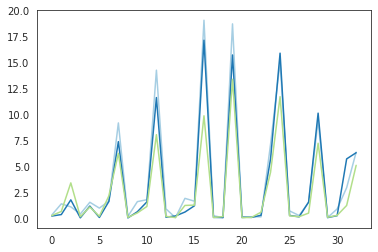

In [31]:
# plot_accumulated(accumulated_ds.precipitation.values[20,:,:],accumulated_ds['lon'].values,accumulated_ds['lat'].values,vmin=0,vmax=20,levels = [0,5,10,15,20],plot='show')


print(accumulated_ds)
print(accumulated_ds.lon.shape)

# havana = accumulated_ds.sel(lat=-82.3666, lon=23.1136, method='nearest')
lat_i = (np.abs(accumulated_ds.lat-(14.5995))).argmin()
lon_i = (np.abs(accumulated_ds.lon-(120.9842))).argmin()
print(lat_i.values)
print(lon_i.values)
lats_i = [lat_i.values-4,lat_i.values+5]
lons_i = [lon_i.values-4,lon_i.values+5]
print(lats_i)
print(lons_i)
print(accumulated_ds.lat[lats_i[0]:lats_i[1]].values)
print(accumulated_ds.lon[lons_i[0]:lons_i[1]].values)
print(accumulated_ds.precipitation.shape)
havana_rain = np.mean(np.mean(accumulated_ds.precipitation[:,lats_i[0]:lats_i[1],lons_i[0]:lons_i[1]].values,axis=1),axis=1)
print(havana_rain.shape)
plt.plot(havana_rain)
havana_rain_pred = np.mean(np.mean(accumulated_ds_pred.precipitation[:,lats_i[0]:lats_i[1],lons_i[0]:lons_i[1]].values,axis=1),axis=1)
plt.plot(havana_rain_pred)
havana_rain_input = np.mean(np.mean(accumulated_ds_input.precipitation[:,lats_i[0]:lats_i[1],lons_i[0]:lons_i[1]].values,axis=1),axis=1)
plt.plot(havana_rain_input)
plt.show()
plt.clf()

# havana = accumulated_ds.sel(lon=-93.15, method='nearest')
# print(accumulated_ds.where(x=-93.15))
# havana = accumulated_ds.sel(precipitation=0, method='nearest')

In [12]:
print(accumulated_ds.precipitation[0].shape)
print(accumulated_ds.lat.shape)
print(accumulated_ds.lon.shape)

(144, 262)
(144,)
(262,)
